Part 1: Structured Data & ML Challenge

Dataset Description 
For this challenge, you'll be working with a retail sales dataset (retail_sales_data.csv)
from a multi-store retail chain. The dataset contains daily sales data from January to December 
2023 across 10 different stores and 5 product categories. 

1. Data Preprocessing (25%)
   
   ○ Load and clean the dataset, addressing missing values appropriately
   
   ○ Perform exploratory data analysis (EDA) to understand patterns and relationships
   
   ○ Engineer relevant features that might improve predictive performance
   
   ○ Prepare the data for modeling (encoding, scaling, etc.) 

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor

In [46]:
data_path = 'C:\repo\AIA_Technical_Assessment\data'

In [47]:
#loading the data
data = pd.read_csv(os.path.join(data_path, 'retail_sales_data.csv'))
data.head()

date store_id     category weather promotion special_event  \
0  2023-01-01  store_1  Electronics   Sunny       NaN         False   
1  2023-01-01  store_1     Clothing   Rainy  Discount         False   
2  2023-01-01  store_1    Groceries   Sunny  Seasonal         False   
3  2023-01-01  store_1   Home Goods   Sunny  Discount         False   
4  2023-01-01  store_1       Beauty   Sunny  Seasonal         False   

  dominant_age_group  num_customers  total_sales  online_sales  \
0              25-34          137.0      1409.76        430.08   
1                55+          116.0      1612.79       1238.71   
2              18-24          120.0      1307.37        168.46   
3                55+          132.0      1756.65        220.98   
4                55+          120.0      1764.91        686.24   

   in_store_sales  avg_transaction  return_rate  
0          979.68            10.29       0.0453  
1          374.07            13.90       0.0407  
2         1138.92            10.89       0.0793  
3         1535.66            13.31       0.0442  
4         1078.67            14.71       0.0234

In [48]:
data.tail()

date  store_id     category weather   promotion special_event  \
18245  2023-12-31  store_10  Electronics   Snowy    Seasonal         False   
18246  2023-12-31  store_10     Clothing   Windy  Flash Sale         False   
18247  2023-12-31  store_10    Groceries   Sunny        BOGO         False   
18248  2023-12-31  store_10   Home Goods  Cloudy        BOGO         False   
18249  2023-12-31  store_10       Beauty   Windy    Discount         False   

      dominant_age_group  num_customers  total_sales  online_sales  \
18245              18-24          101.0      1545.95        969.54   
18246              18-24          160.0      1721.38       1157.01   
18247              45-54          187.0      2787.41       1007.79   
18248              35-44          148.0       866.32        412.21   
18249              45-54          146.0      1711.93        847.53   

       in_store_sales  avg_transaction  return_rate  
18245          576.41            15.31       0.0519  
18246          564.37            10.76          NaN  
18247         1779.62            14.91       0.0191  
18248          454.12             5.85       0.0382  
18249          864.40            11.73       0.0443

In [49]:
# Checking data types and missing values
# This is useful to identify columns with categorical data that will need encoding, as well as numerical columns that may require data cleaning.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                18250 non-null  object 
 1   store_id            18250 non-null  object 
 2   category            18250 non-null  object 
 3   weather             17904 non-null  object 
 4   promotion           14369 non-null  object 
 5   special_event       17868 non-null  object 
 6   dominant_age_group  17862 non-null  object 
 7   num_customers       17852 non-null  float64
 8   total_sales         17892 non-null  float64
 9   online_sales        17896 non-null  float64
 10  in_store_sales      17862 non-null  float64
 11  avg_transaction     17876 non-null  float64
 12  return_rate         17893 non-null  float64
dtypes: float64(6), object(7)
memory usage: 1.8+ MB


In [50]:
# View summary statistics. Provides summary statistics, including measures like mean, standard deviation, minimum, and maximum values for numerical columns.
data.describe()

num_customers   total_sales  online_sales  in_store_sales  \
count   17852.000000  17892.000000  17896.000000    17862.000000   
mean      106.242382   1311.541712    526.816265      785.157977   
std        24.347909    418.386731    323.639622      370.713369   
min        51.000000    250.010000      2.000000       13.260000   
25%        89.000000   1015.697500    286.060000      517.352500   
50%       102.000000   1257.690000    469.340000      737.240000   
75%       119.000000   1539.222500    701.555000      998.587500   
max       285.000000   4202.360000   3371.680000     3178.170000   

       avg_transaction   return_rate  
count     17876.000000  17893.000000  
mean         12.482732      0.049979  
std           3.311998      0.020041  
min           2.620000     -0.026900  
25%          10.130000      0.036400  
50%          12.210000      0.050000  
75%          14.550000      0.063400  
max          27.860000      0.136600

In [51]:
# Convert the date column to date format
data["date"] = pd.to_datetime(data["date"])

#Deriving more data from the date variable for insight
data['day_of_week'] = data['date'].dt.day_name()
data["Is Weekend"] = data['date'].dt.dayofweek > 4
data['Month'] = data['date'].dt.month_name()

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                18250 non-null  datetime64[ns]
 1   store_id            18250 non-null  object        
 2   category            18250 non-null  object        
 3   weather             17904 non-null  object        
 4   promotion           14369 non-null  object        
 5   special_event       17868 non-null  object        
 6   dominant_age_group  17862 non-null  object        
 7   num_customers       17852 non-null  float64       
 8   total_sales         17892 non-null  float64       
 9   online_sales        17896 non-null  float64       
 10  in_store_sales      17862 non-null  float64       
 11  avg_transaction     17876 non-null  float64       
 12  return_rate         17893 non-null  float64       
 13  day_of_week         18250 non-null  object    

In [53]:
data['promotion'].unique()

array([nan, 'Discount', 'Seasonal', 'BOGO', 'Flash Sale'], dtype=object)

HANDLING MISSING VALUES

In [54]:
#assumption that blank values stood in for no promotions
data.loc[data['promotion'].isnull(),'promotion']="No promotion"

In [55]:
#correcting for negative return rate
data['return_rate'] = data['return_rate'].abs()


In [56]:
#number or missing values in each column
data.isnull().sum()

date                    0
store_id                0
category                0
weather               346
promotion               0
special_event         382
dominant_age_group    388
num_customers         398
total_sales           358
online_sales          354
in_store_sales        388
avg_transaction       374
return_rate           357
day_of_week             0
Is Weekend              0
Month                   0
dtype: int64

In [57]:
#calculate the percentage of missing values in each column
(data.isnull().sum()/(len(data)))*100

date                  0.000000
store_id              0.000000
category              0.000000
weather               1.895890
promotion             0.000000
special_event         2.093151
dominant_age_group    2.126027
num_customers         2.180822
total_sales           1.961644
online_sales          1.939726
in_store_sales        2.126027
avg_transaction       2.049315
return_rate           1.956164
day_of_week           0.000000
Is Weekend            0.000000
Month                 0.000000
dtype: float64

In [58]:
#deleted the rows with null values
data_minus_null = data.loc[(data['weather'].notnull()) &
                      (data['special_event'].notnull()) &
                      (data['dominant_age_group'].notnull()) &
                      (data['num_customers'].notnull()) &
                      (data['total_sales'].notnull()) &
                      (data['online_sales'].notnull()) &
                      (data['in_store_sales'].notnull()) &
                      (data['avg_transaction'].notnull()) &
                      (data['return_rate'].notnull())
]

In [59]:
#the percentage of clean_data with respect to original data to decide whether to use the clean_data or transform the data
((len(data_minus_null)/(len(data)))*100)

82.96438356164384

In [60]:
data_clean = data

# Fill missing categorical values with 'Unknown'
cat_cols = ['weather', 'special_event', 'dominant_age_group']
data_clean[cat_cols] = data_clean[cat_cols].fillna('Unknown')

# Fill missing numerical values with median
numerical_cols = ['num_customers', 'total_sales', 'online_sales', 'in_store_sales', 'avg_transaction', 'return_rate']
for col in numerical_cols:
    data_clean[col] = data_clean[col].fillna(data_clean[col].median())

In [61]:
# Sort data for lag feature creation
data_clean = data_clean.sort_values(by=['store_id', 'category', 'date'])

# Create lag features for total sales (1-day, 7-day, 14-day)
for lag in [1, 7, 14]:
    data_clean[f'total_sales_lag_{lag}'] = data_clean.groupby(['store_id', 'category'])['total_sales'].shift(lag)

# Moving average features (7-day and 14-day rolling mean)
for window in [7, 14]:
    data_clean[f'total_sales_ma_{window}'] = data_clean.groupby(['store_id', 'category'])['total_sales'].transform(lambda x: x.rolling(window, min_periods=1).mean())

In [62]:
#giving all statistics summary of data
data_clean.describe().T

count                           mean  \
date                  18250  2023-07-02 00:00:00.000000256   
num_customers       18250.0                     106.149863   
total_sales         18250.0                    1310.485333   
online_sales        18250.0                     525.701383   
in_store_sales      18250.0                     784.139227   
avg_transaction     18250.0                      12.477143   
return_rate         18250.0                       0.050051   
total_sales_lag_1   18200.0                    1309.052976   
total_sales_lag_7   17900.0                    1307.298884   
total_sales_lag_14  17550.0                     1304.91631   
total_sales_ma_7    18250.0                    1307.544589   
total_sales_ma_14   18250.0                    1305.064006   

                                    min                  25%  \
date                2023-01-01 00:00:00  2023-04-02 00:00:00   
num_customers                      51.0                 90.0   
total_sales                      250.01             1021.745   
online_sales                        2.0             290.2075   
in_store_sales                    13.26               521.64   
avg_transaction                    2.62                10.17   
return_rate                         0.0             0.036725   
total_sales_lag_1                250.01            1021.1125   
total_sales_lag_7                250.01              1018.76   
total_sales_lag_14               250.01            1016.8575   
total_sales_ma_7                 483.83          1187.809286   
total_sales_ma_14                483.83          1207.913571   

                                    50%                  75%  \
date                2023-07-02 00:00:00  2023-10-01 00:00:00   
num_customers                     102.0                118.0   
total_sales                     1257.69            1531.3775   
online_sales                     469.34             696.3675   
in_store_sales                   737.24             991.2825   
avg_transaction                   12.21                14.49   
return_rate                        0.05               0.0631   
total_sales_lag_1               1257.69             1529.745   
total_sales_lag_7               1257.69             1528.825   
total_sales_lag_14              1257.69            1524.6875   
total_sales_ma_7            1297.092857          1414.002857   
total_sales_ma_14           1298.134643          1396.645357   

                                    max         std  
date                2023-12-31 00:00:00         NaN  
num_customers                     285.0    24.08891  
total_sales                     4202.36  414.329864  
online_sales                    3371.68   320.58324  
in_store_sales                  3178.17  366.816381  
avg_transaction                   27.86    3.278111  
return_rate                      0.1366    0.019664  
total_sales_lag_1               4202.36  413.061437  
total_sales_lag_7               4202.36  412.528353  
total_sales_lag_14              4202.36  411.552866  
total_sales_ma_7                2690.05  170.189317  
total_sales_ma_14               2690.05  137.477986

From the statistics summary, we can infer the below findings at a quick glance:
- The range of customers range between 51-285 within the stors, with an average of 106 customers per day.
- The range of total sales range between 250.01 - 4202.36 within the stores, with an average of 1310.48 sales per day.
- The range of online sales range between 2.0 - 3371.68 within the stores, with an average of 525.70 sales per day.
- The range of instore sales range between 13.26 - 3178.17 within the stores, with an average of 784.13 sales per day. Performing better than the online store sales. 
- The range of average transactions range between 2.62 - 27.86 within the stores, with an average of 12.477143 per day.




In [63]:
#Before doing Exploratory Data Analysis (EDA), I separate Numerical and categorical variables
'''Exploratory Data Analysis refers to the crucial process of performing initial investigations on data to discover patterns to check assumptions with the help of summary statistics and graphical representations.
    EDA can be leveraged to check for outliers, patterns, and trends in the given data.
    EDA helps to find meaningful patterns in data.
    EDA provides in-depth insights into the data sets to solve our business problems.
    EDA gives a clue to impute missing values in the dataset '''

cat_cols=data_clean.select_dtypes(include=['object']).columns
num_cols = data_clean.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:", cat_cols)
print("Numerical Variables:",num_cols)

Categorical Variables: Index(['store_id', 'category', 'weather', 'promotion', 'special_event',
       'dominant_age_group', 'day_of_week', 'Month'],
      dtype='object')
Numerical Variables: ['num_customers', 'total_sales', 'online_sales', 'in_store_sales', 'avg_transaction', 'return_rate', 'total_sales_lag_1', 'total_sales_lag_7', 'total_sales_lag_14', 'total_sales_ma_7', 'total_sales_ma_14']


num_customers
Skew : 1.17


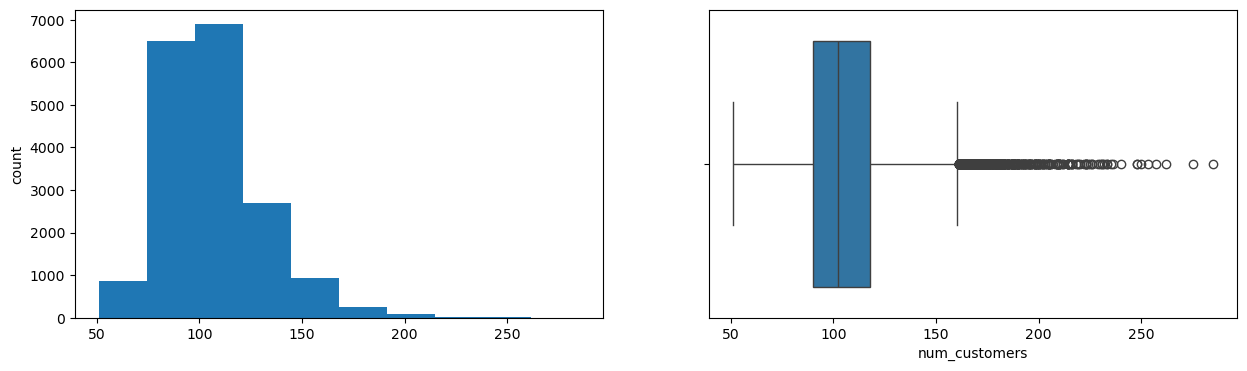

total_sales
Skew : 0.98


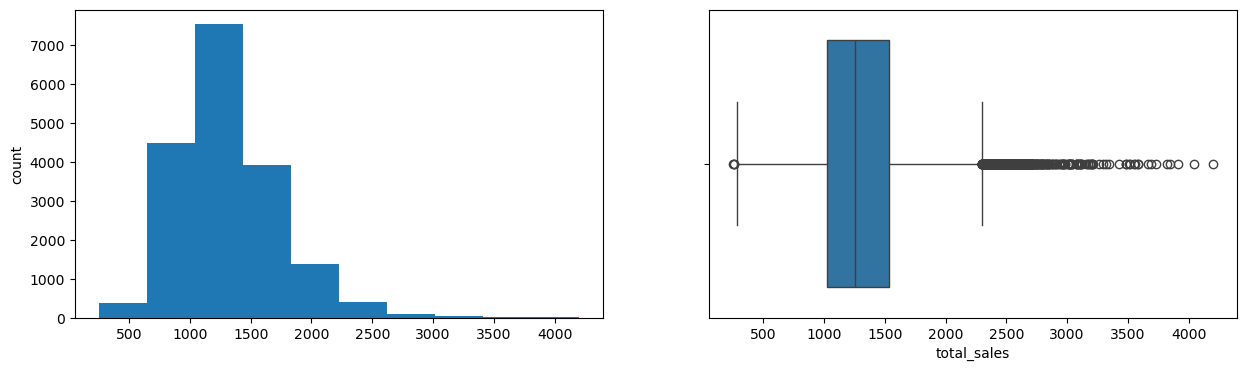

online_sales
Skew : 1.2


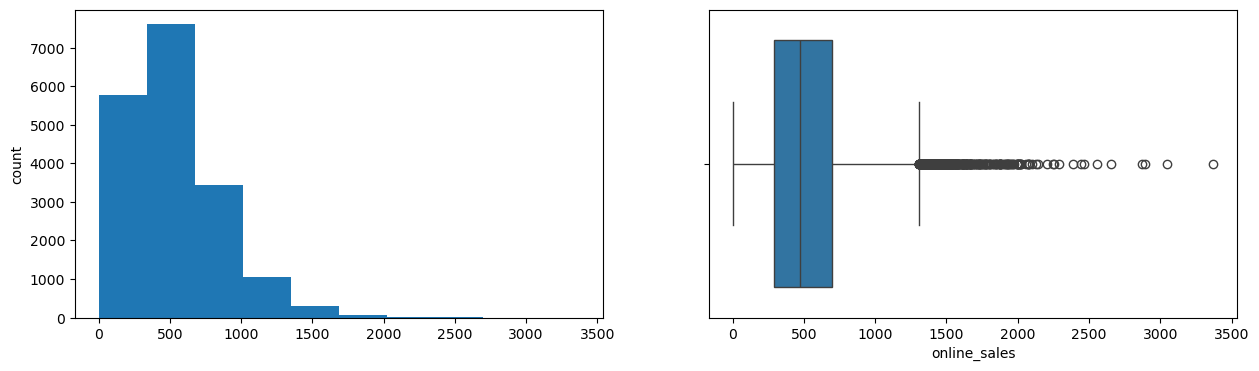

in_store_sales
Skew : 0.89


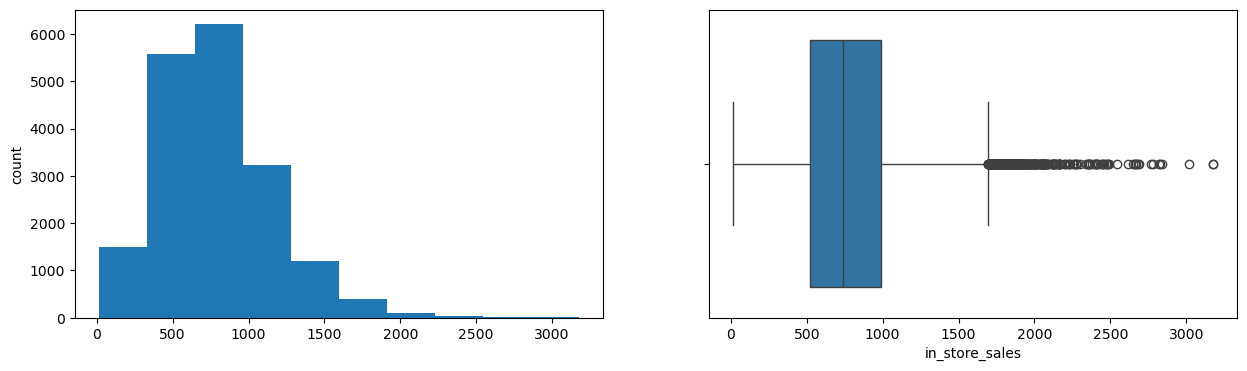

avg_transaction
Skew : 0.46


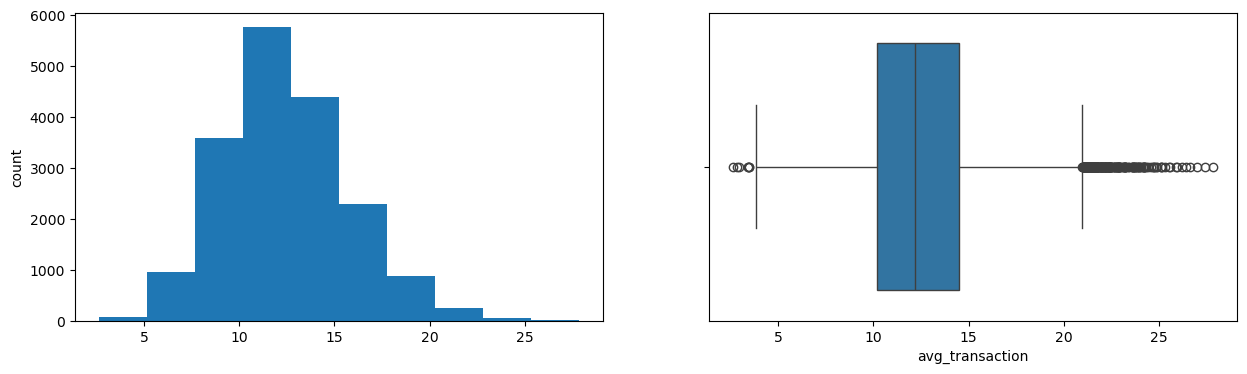

return_rate
Skew : 0.09


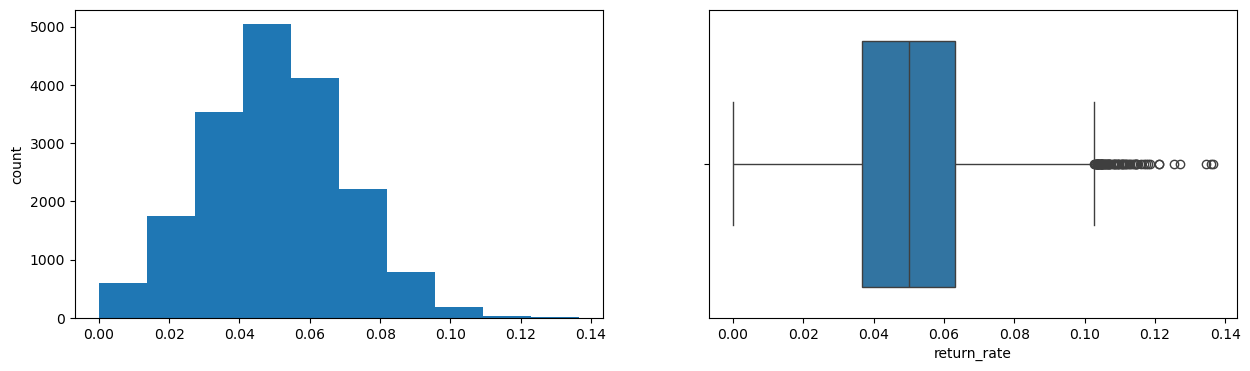

total_sales_lag_1
Skew : 0.97


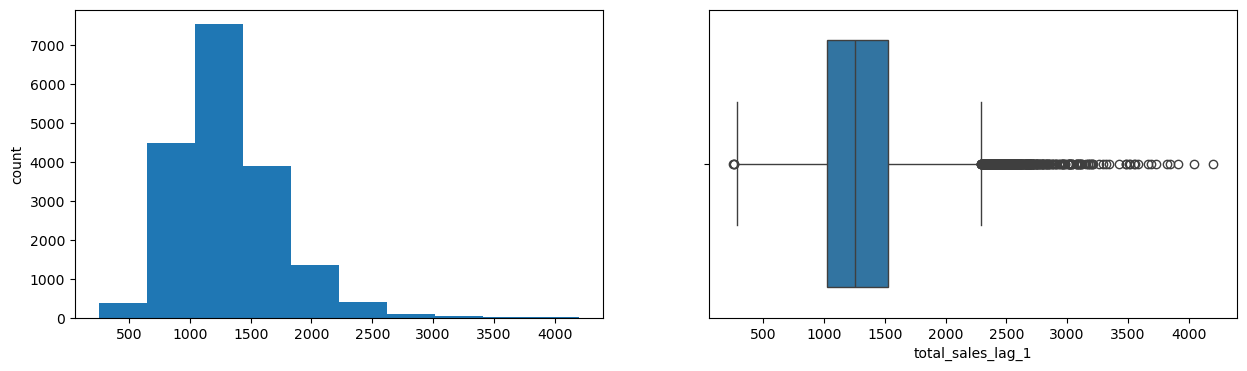

total_sales_lag_7
Skew : 0.97


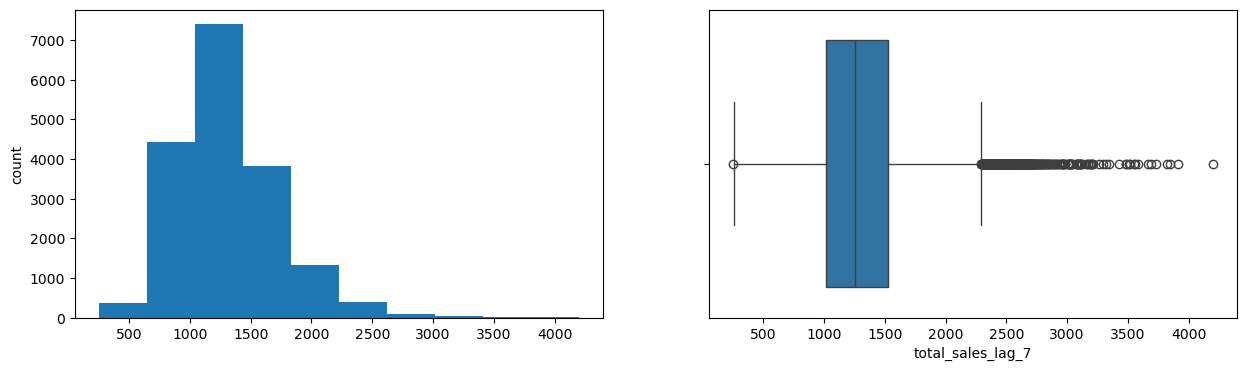

total_sales_lag_14
Skew : 0.96


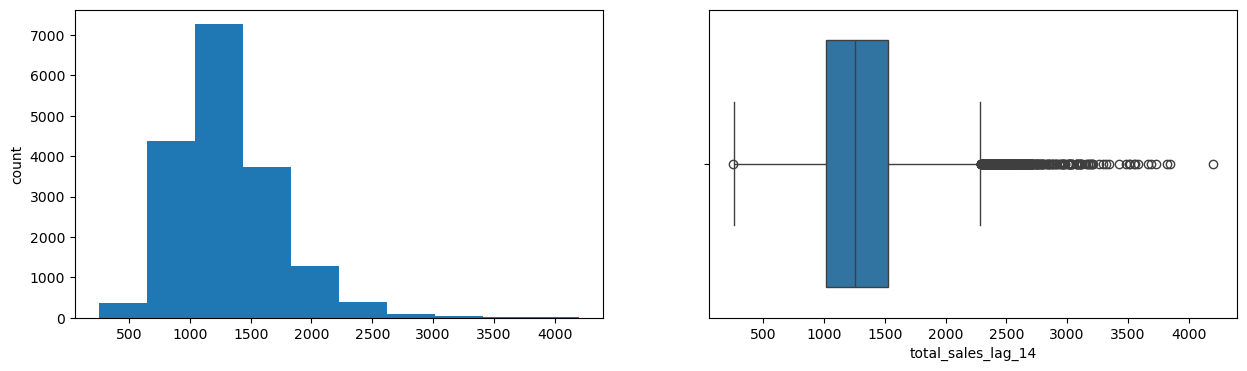

total_sales_ma_7
Skew : 0.39


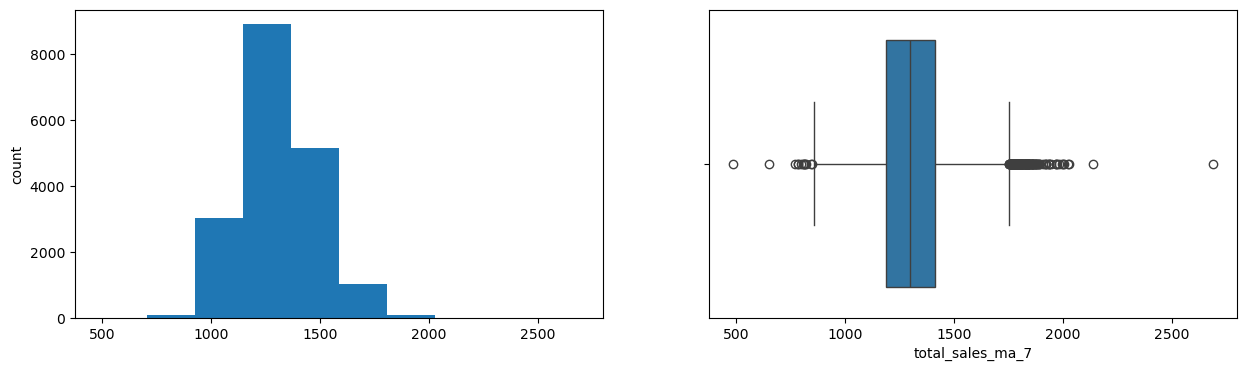

total_sales_ma_14
Skew : 0.28


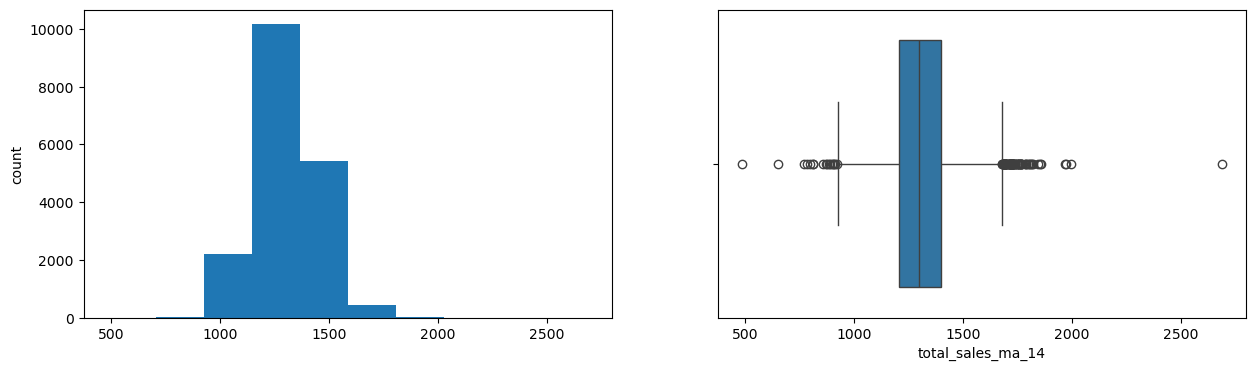

In [64]:
#creating histograms for the numerical variables
for col in num_cols:
    print(col)
    print('Skew :', round(data_clean[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data_clean[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_clean[col])
    plt.show()

#INTERPRETING HISTOGRAMS AND BOXPLOTS
- Customer numbers at an interquartile range of  80-120.
- Total sales at an interquartile range of 1000 - 1500.
- Online sales at an interquartile range of 300 - 700.
- Instore sales at an interquartile range of 500 - 1000.
- Average transactions at an interquartile range of 10 - 15. 
- Return rate ranging at an interquartile range of 0.04 - 0.06







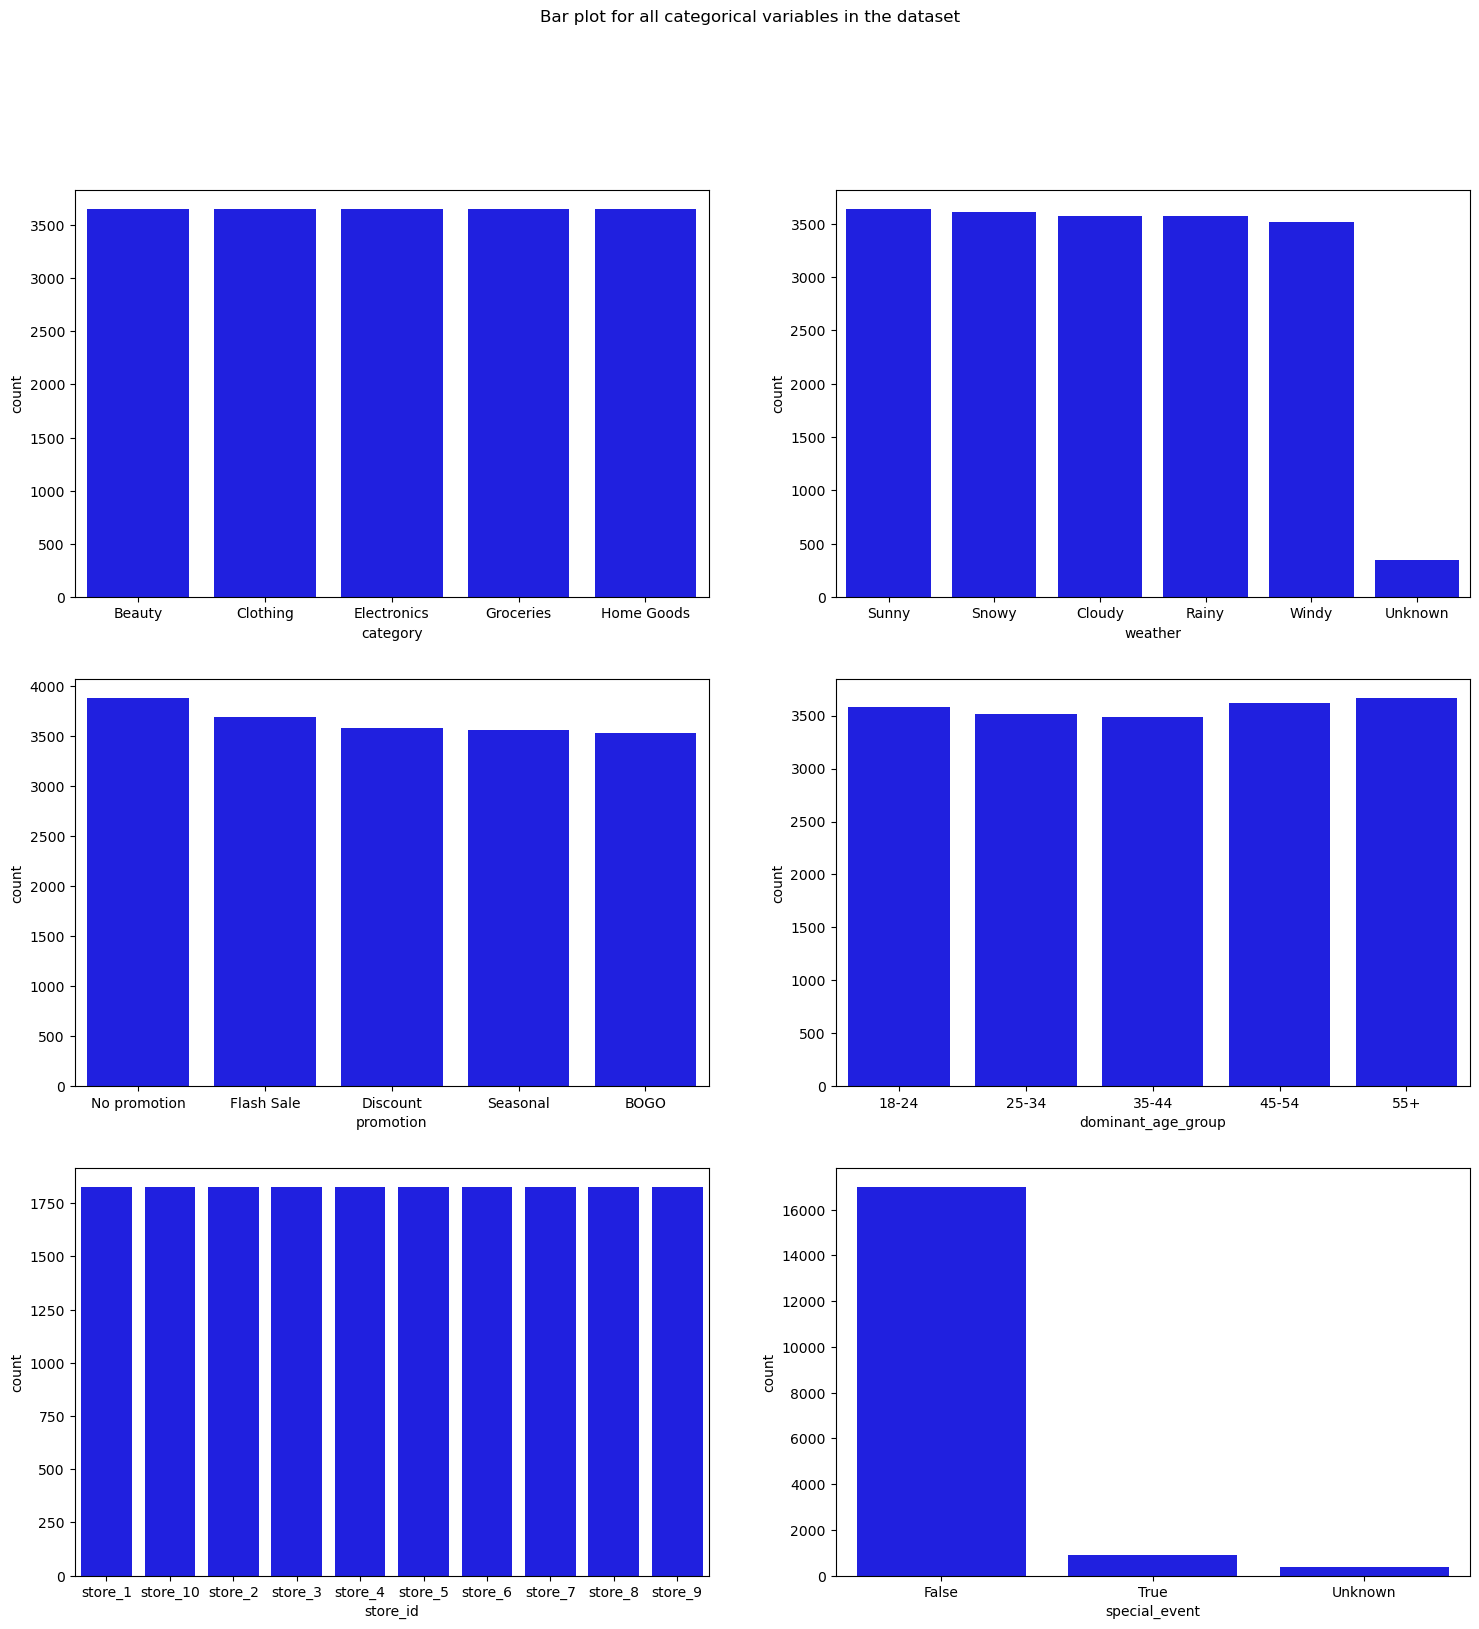

In [65]:
fig, axes = plt.subplots(3, 2, figsize = (18, 18))
fig.suptitle('Bar plot for all categorical variables in the dataset')
sns.countplot(ax = axes[0, 0], x = 'category', data = data_clean, color = 'blue',
              order = data_clean['category'].value_counts().index);
sns.countplot(ax = axes[0, 1], x = 'weather', data = data_clean, color = 'blue',
              order = data_clean['weather'].value_counts().index);
sns.countplot(ax = axes[1, 0], x = 'promotion', data = data_clean, color = 'blue',
              order = data_clean['promotion'].value_counts().index);
sns.countplot(ax = axes[1, 1], x = 'dominant_age_group', data = data_clean, color = 'blue',
              order = [ '18-24', '25-34','35-44', '45-54','55+']);
sns.countplot(ax = axes[2, 0], x = 'store_id', data = data_clean, color = 'blue',
              order = data_clean['store_id'].value_counts().index);
sns.countplot(ax = axes[2, 1], x = 'special_event', data = data_clean, color = 'blue',
              order = data_clean['special_event'].value_counts().index);


Reporting: 
- There is a balance between majority of the categorical variables: Categories, Weather, Promotions, Dominant Age groups and Store ID
- However th Special events vary greatly




<Figure size 1300x1700 with 0 Axes>

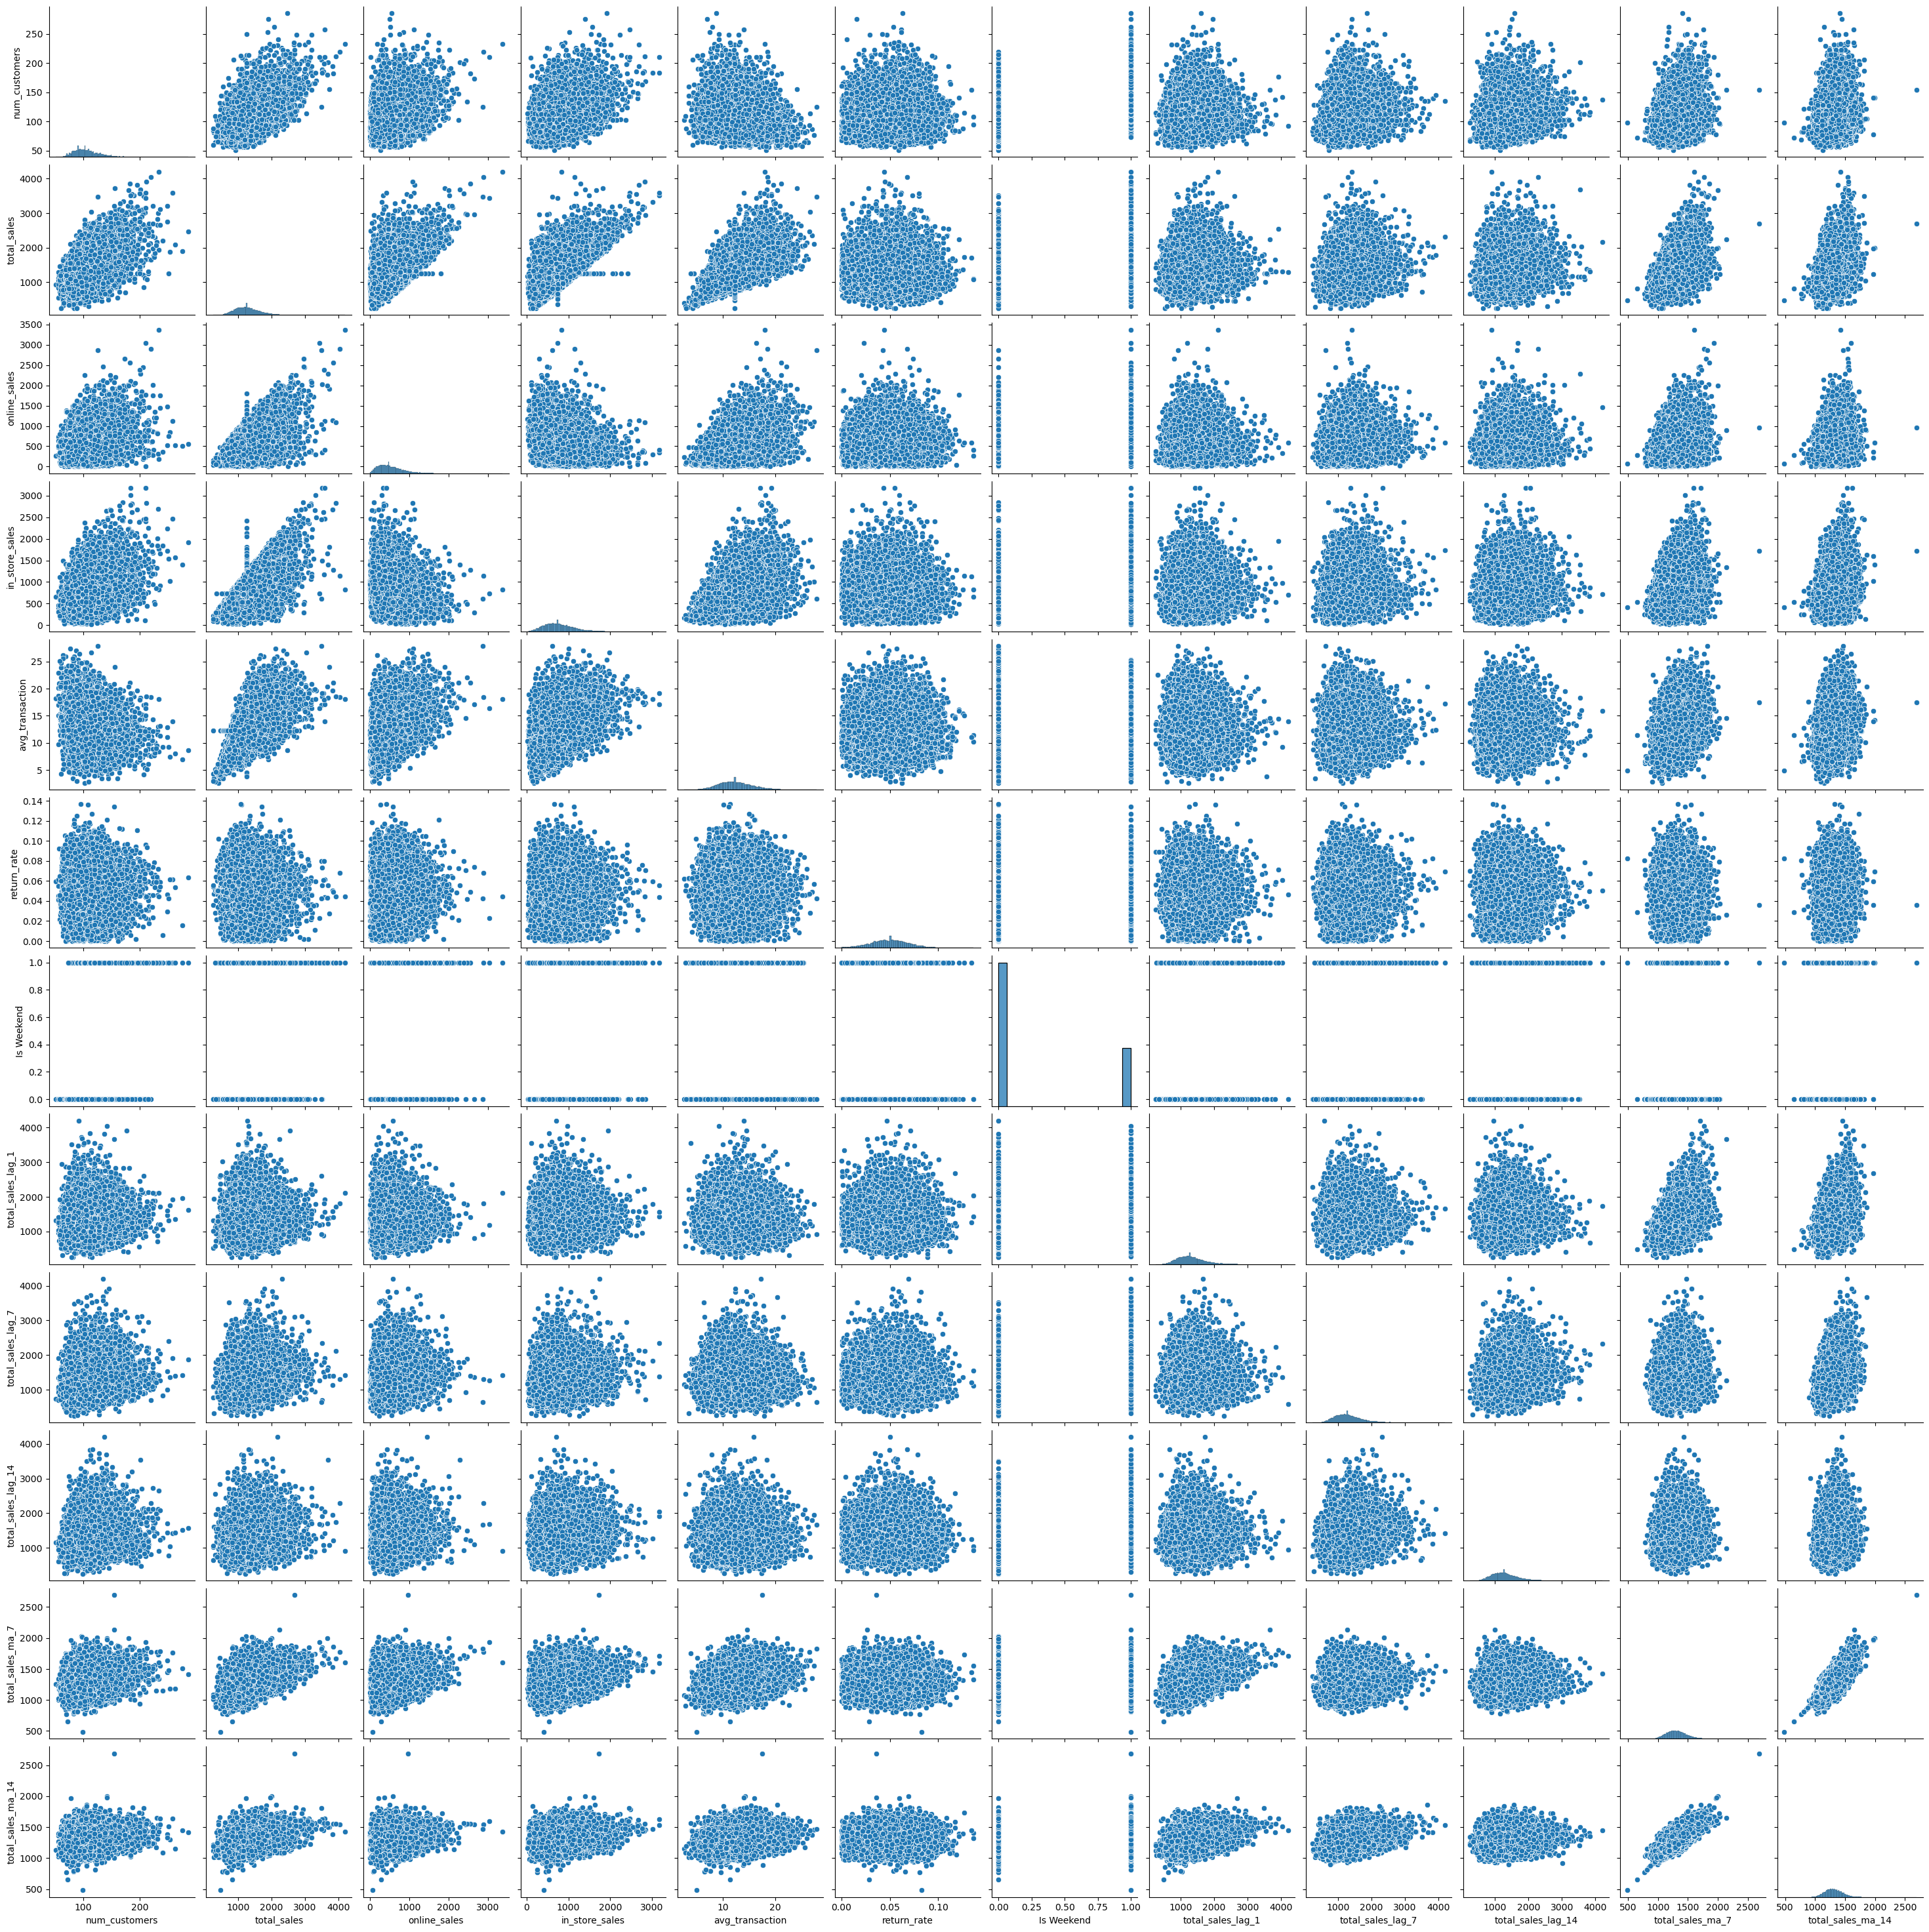

In [66]:
#EDA Bivariate Analysis
plt.figure(figsize=(13,17))
sns.pairplot(data=data_clean)
plt.show()

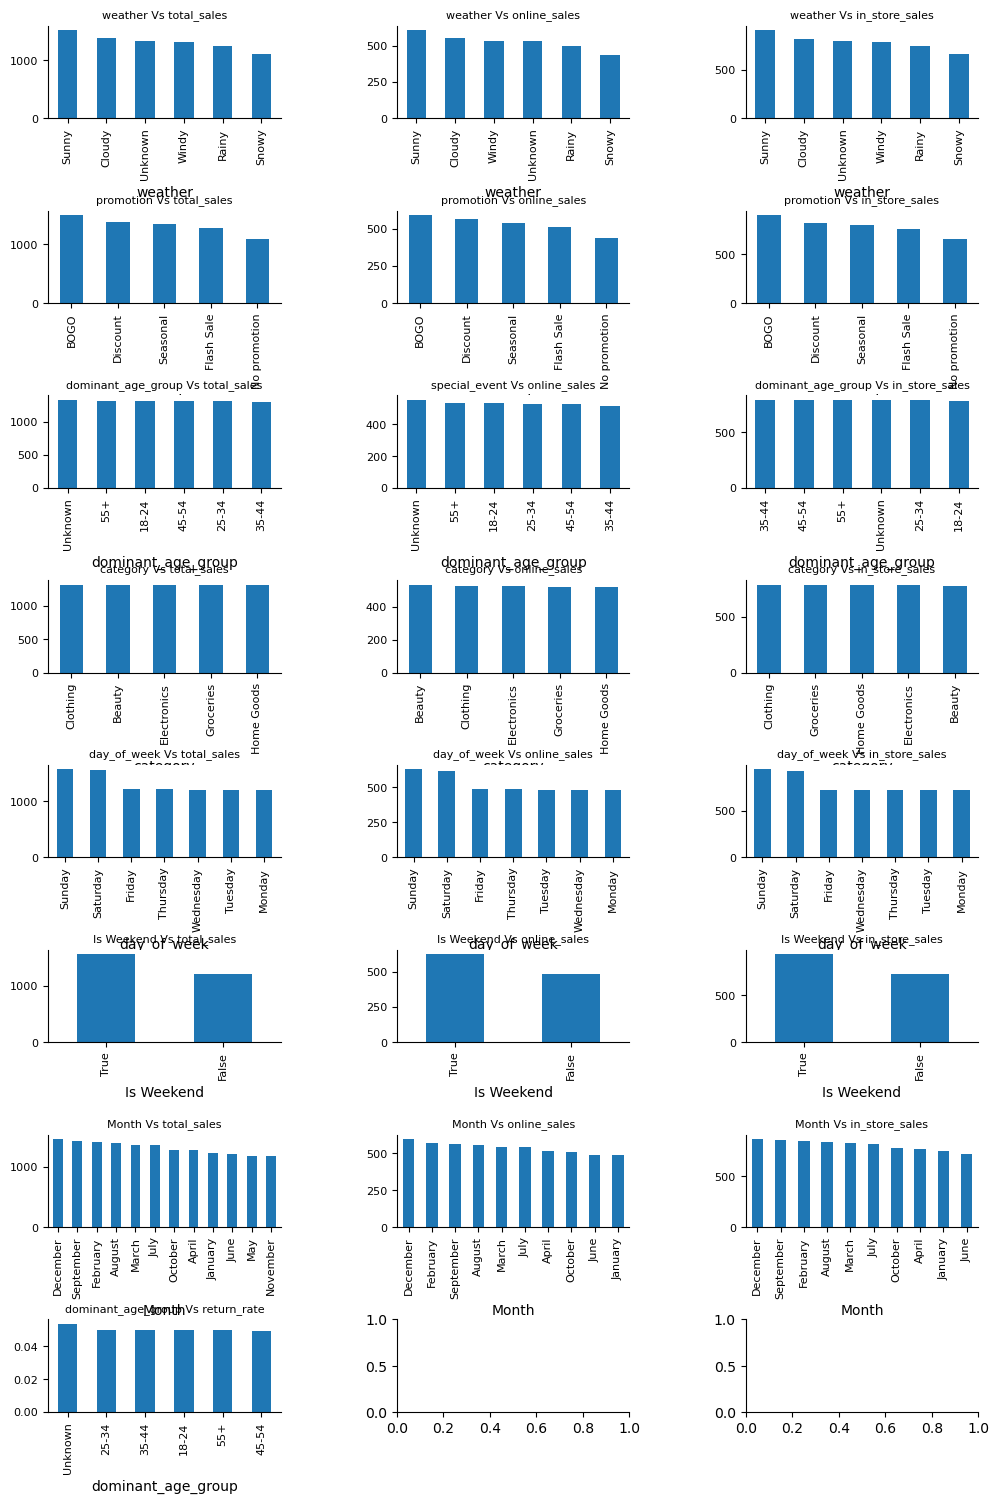

In [67]:
#Using a bar plot to show the relationship between Categorical variables and continuous variables

fig, axarr = plt.subplots(8, 3, figsize=(12, 18))
data_clean.groupby('weather')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][0], fontsize=8)
axarr[0][0].set_title("weather Vs total_sales", fontsize=8)
data_clean.groupby('weather')['online_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][1], fontsize=8)
axarr[0][1].set_title("weather Vs online_sales", fontsize=8)
data_clean.groupby('weather')['in_store_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][2], fontsize=8)
axarr[0][2].set_title("weather Vs in_store_sales", fontsize=8)

data_clean.groupby('promotion')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[1][0], fontsize=8)
axarr[1][0].set_title("promotion Vs total_sales", fontsize=8)
data_clean.groupby('promotion')['online_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[1][1], fontsize=8)
axarr[1][1].set_title("promotion Vs online_sales", fontsize=8)
data_clean.groupby('promotion')['in_store_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[1][2], fontsize=8)
axarr[1][2].set_title("promotion Vs in_store_sales", fontsize=8)

data_clean.groupby('dominant_age_group')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[2][0], fontsize=8)
axarr[2][0].set_title("dominant_age_group Vs total_sales", fontsize=8)
data_clean.groupby('dominant_age_group')['online_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[2][1], fontsize=8)
axarr[2][1].set_title("special_event Vs online_sales", fontsize=8)
data_clean.groupby('dominant_age_group')['in_store_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[2][2], fontsize=8)
axarr[2][2].set_title("dominant_age_group Vs in_store_sales", fontsize=8)

data_clean.groupby('category')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[3][0], fontsize=8)
axarr[3][0].set_title("category Vs total_sales", fontsize=8)
data_clean.groupby('category')['online_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[3][1], fontsize=8)
axarr[3][1].set_title("category Vs online_sales", fontsize=8)
data_clean.groupby('category')['in_store_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[3][2], fontsize=8)
axarr[3][2].set_title("category Vs in_store_sales", fontsize=8)

data_clean.groupby('day_of_week')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[4][0], fontsize=8)
axarr[4][0].set_title("day_of_week Vs total_sales", fontsize=8)
data_clean.groupby('day_of_week')['online_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[4][1], fontsize=8)
axarr[4][1].set_title("day_of_week Vs online_sales", fontsize=8)
data_clean.groupby('day_of_week')['in_store_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[4][2], fontsize=8)
axarr[4][2].set_title("day_of_week Vs in_store_sales", fontsize=8)

data_clean.groupby('Is Weekend')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[5][0], fontsize=8)
axarr[5][0].set_title("Is Weekend Vs total_sales", fontsize=8)
data_clean.groupby('Is Weekend')['online_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[5][1], fontsize=8)
axarr[5][1].set_title("Is Weekend Vs online_sales", fontsize=8)
data_clean.groupby('Is Weekend')['in_store_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[5][2], fontsize=8)
axarr[5][2].set_title("Is Weekend Vs in_store_sales", fontsize=8)

data_clean.groupby('Month')['total_sales'].mean().sort_values(ascending=False).plot.bar(ax=axarr[6][0], fontsize=8)
axarr[6][0].set_title("Month Vs total_sales", fontsize=8)
data_clean.groupby('Month')['online_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[6][1], fontsize=8)
axarr[6][1].set_title("Month Vs online_sales", fontsize=8)
data_clean.groupby('Month')['in_store_sales'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[6][2], fontsize=8)
axarr[6][2].set_title("Month Vs in_store_sales", fontsize=8)

data_clean.groupby('dominant_age_group')['return_rate'].mean().sort_values(ascending=False).plot.bar(ax=axarr[7][0], fontsize=8)
axarr[7][0].set_title("dominant_age_group Vs return_rate", fontsize=8)
plt.subplots_adjust(hspace=1.0)
plt.subplots_adjust(wspace=.5)
sns.despine()

In [68]:
# Creating subplots
fig = make_subplots(rows=8, cols=3, subplot_titles=[
    "weather Vs total_sales", "weather Vs online_sales", "weather Vs in_store_sales",
    "promotion Vs total_sales", "promotion Vs online_sales", "promotion Vs in_store_sales",
    "dominant_age_group Vs total_sales", "dominant_age_group Vs online_sales", "dominant_age_group Vs in_store_sales",
    "category Vs total_sales", "category Vs online_sales", "category Vs in_store_sales",
    "day_of_week Vs total_sales", "day_of_week Vs online_sales", "day_of_week Vs in_store_sales",
    "Is Weekend Vs total_sales", "Is Weekend Vs online_sales", "Is Weekend Vs in_store_sales",
    "Month Vs total_sales", "Month Vs online_sales", "Month Vs in_store_sales",
    "dominant_age_group Vs return_rate"
])

# Define categories and metrics
categories = ['weather', 'promotion', 'dominant_age_group', 'category', 'day_of_week', 'Is Weekend', 'Month']
metrics = ['total_sales', 'online_sales', 'in_store_sales']

# Adding traces for each category-metric pair
row_idx = 1
for category in categories:
    col_idx = 1
    for metric in metrics:
        grouped_data = data_clean.groupby(category)[metric].mean().sort_values(ascending=False)
        fig.add_trace(
            go.Bar(x=grouped_data.index, y=grouped_data.values, name=f"{category} Vs {metric}"),
            row=row_idx, col=col_idx
        )
        col_idx += 1
    row_idx += 1

# Adding the last subplot for return_rate
grouped_data = data_clean.groupby('dominant_age_group')['return_rate'].mean().sort_values(ascending=False)
fig.add_trace(
    go.Bar(x=grouped_data.index, y=grouped_data.values, name="dominant_age_group Vs return_rate"),
    row=8, col=1
)

# Update layout
fig.update_layout(height=2000, width=1200, showlegend=False, title_text="Categorical Variables Vs Continuous Variables")
fig.show()

3. Customer Segmentation (25%)
 
    ○ Using the available features, segment stores into meaningful groups

    ○ Provide actionable insights for each segment

    ○ Suggest store-specific strategies based on your analysis 


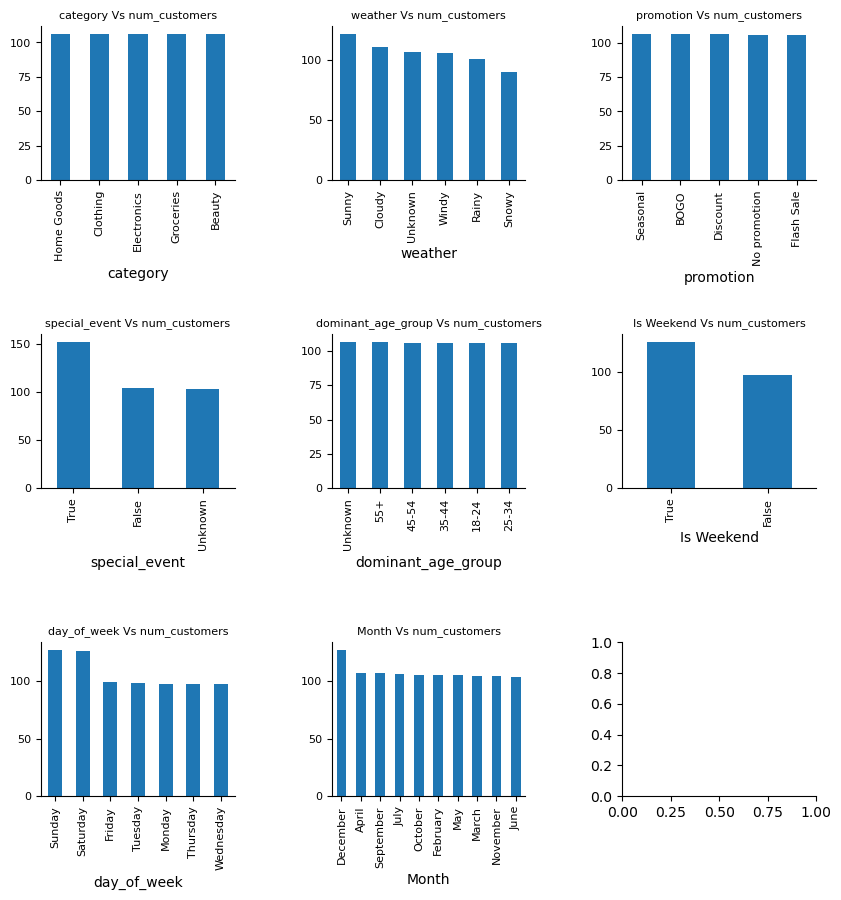

In [69]:
#Using a bar plot to show the relationship between Categorical variables and continuous variables

fig, axarr = plt.subplots(3, 3, figsize=(10, 10))
data_clean.groupby('category')['num_customers'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][0], fontsize=8)
axarr[0][0].set_title("category Vs num_customers", fontsize=8)
data_clean.groupby('weather')['num_customers'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][1], fontsize=8)
axarr[0][1].set_title("weather Vs num_customers", fontsize=8)
data_clean.groupby('promotion')['num_customers'].mean().sort_values(ascending=False).plot.bar(ax=axarr[0][2], fontsize=8)
axarr[0][2].set_title("promotion Vs num_customers", fontsize=8)

data_clean.groupby('special_event')['num_customers'].mean().sort_values(ascending=False).plot.bar(ax=axarr[1][0], fontsize=8)
axarr[1][0].set_title("special_event Vs num_customers", fontsize=8)
data_clean.groupby('dominant_age_group')['num_customers'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[1][1], fontsize=8)
axarr[1][1].set_title("dominant_age_group Vs num_customers", fontsize=8)
data_clean.groupby('Is Weekend')['num_customers'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[1][2], fontsize=8)
axarr[1][2].set_title("Is Weekend Vs num_customers", fontsize=8)

data_clean.groupby('day_of_week')['num_customers'].mean().sort_values(ascending=False).plot.bar(ax=axarr[2][0], fontsize=8)
axarr[2][0].set_title("day_of_week Vs num_customers", fontsize=8)
data_clean.groupby('Month')['num_customers'].mean().sort_values(ascending=False).head(10).plot.bar(ax=axarr[2][1], fontsize=8)
axarr[2][1].set_title("Month Vs num_customers", fontsize=8)


plt.subplots_adjust(hspace=1.0)
plt.subplots_adjust(wspace=.5)
sns.despine()

CUSTOMER SEGMENT INSIGHTS
There was a higher number of customers:
- On weekends, where more customers were registered on both Saturday and Sunday
- In December, where the number of customers were notably higher than all other months
- On Sunny days, the highest number of customers were recorded followed by Cloudy, Windy, Rainy and Snowing, as the weather condtioned worsened.
- Where promotions and special events were offered


2. Sales Forecasting (50%)

    ○ Develop a machine learning model to forecast the daily total_sales for each 
store-category combination

   ○ Create a 14-day forecast for January 2024 (beyond the dataset timeframe)

   ○ Evaluate your model using appropriate metrics

   ○ Analyze which features are most important for sales prediction 

 Prepare the data for modeling (encoding, scaling, etc.) 

In [70]:
#Encoding Categorical Features: I’ll use one-hot encoding to create binary columns for each category, allowing the model to interpret them without assigning an arbitrary order.
data_encode = data_clean.copy()

### Naïve Forecasting (Baseline Model)

In [71]:
# Naïve Forecast: Next day's sales = Last observed sales
data_encode["naive_forecast"] = data_encode["total_sales"].shift(1)

data_encode = data_encode.dropna(subset=['total_sales', 'naive_forecast'])
# Evaluate Naïve Model
mae_naive = mean_absolute_error(data_encode["total_sales"], data_encode["naive_forecast"])
rmse_naive = np.sqrt(mean_squared_error(data_encode["total_sales"], data_encode["naive_forecast"]))

print(f"Naïve Model - MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}")


Naïve Model - MAE: 427.12, RMSE: 554.36


In [72]:
data_encode.columns

Index(['date', 'store_id', 'category', 'weather', 'promotion', 'special_event',
       'dominant_age_group', 'num_customers', 'total_sales', 'online_sales',
       'in_store_sales', 'avg_transaction', 'return_rate', 'day_of_week',
       'Is Weekend', 'Month', 'total_sales_lag_1', 'total_sales_lag_7',
       'total_sales_lag_14', 'total_sales_ma_7', 'total_sales_ma_14',
       'naive_forecast'],
      dtype='object')

In [73]:
data_encode.loc[data_encode['special_event'] == False, 'special_event']= 0
data_encode.loc[data_encode['special_event'] == True, 'special_event']= 1
data_encode.loc[data_encode['special_event'] == 'Unknown', 'special_event']= 2

In [74]:
# One-hot encode categorical columns
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols.to_list():
    data_encode[col]= label_encoder.fit_transform(data_encode[col])

# One-hot encode categorical columns:boolean
encoder = LabelEncoder()
data_encode['Is Weekend'] = encoder.fit_transform(data_encode['Is Weekend'])


In [75]:
# Scale numerical columns
scaler = StandardScaler()
numerical_features = num_cols
data_encode[numerical_features] = scaler.fit_transform(data_encode[numerical_features])


In [76]:
# Define features and target variable
target = 'total_sales'
X = data_encode.drop(columns=[target])
y = data_encode[target]


In [77]:
# Get all column names after one-hot encoding
encoded_features = [col for col in data_encode.columns if col not in ['total_sales', 'date']]

# Split the dataset again with correct features
train_data, val_data = train_test_split(data_encode, test_size=0.2, shuffle=False, random_state=42)
X_train, y_train = train_data[encoded_features], train_data[target]
X_val, y_val = val_data[encoded_features], val_data[target]



In [78]:
# Retrain the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Calculate performance metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

mae, rmse

(0.0752839376441469, np.float64(0.1763500858101939))